## Predictive modeling of customer bookings
Problem Statement: To find out and understand factors that would influence travellers to complete their travel booking.

### Modelling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("data/customer_booking_cleaned.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [10]:
# save column names in a list
cols = df.columns.tolist()

# for categorical variables, count the number of unique values
df[cols].nunique()

num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            452
length_of_stay           313
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49959 entries, 0 to 49958
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49959 non-null  int64  
 1   sales_channel          49959 non-null  object 
 2   trip_type              49959 non-null  object 
 3   purchase_lead          49959 non-null  int64  
 4   length_of_stay         49959 non-null  int64  
 5   flight_hour            49959 non-null  int64  
 6   flight_day             49959 non-null  int64  
 7   route                  49959 non-null  object 
 8   booking_origin         49959 non-null  object 
 9   wants_extra_baggage    49959 non-null  int64  
 10  wants_preferred_seat   49959 non-null  int64  
 11  wants_in_flight_meals  49959 non-null  int64  
 12  flight_duration        49959 non-null  float64
 13  booking_complete       49959 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.3+ 

In [12]:
# Drop the route and booking origin columns
df.drop(['route', 'booking_origin'], axis=1, inplace=True)

In [14]:
# One-hot encode the categorical variables
df = pd.get_dummies(df, drop_first=True)

df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip
0,2,262,19,7,6,1,0,0,5.52,0,0,0,1
1,1,112,20,3,6,0,0,0,5.52,0,0,0,1
2,2,243,22,17,3,1,1,0,5.52,0,0,0,1
3,1,96,31,4,6,0,0,1,5.52,0,0,0,1
4,2,68,22,15,3,1,0,1,5.52,0,0,0,1


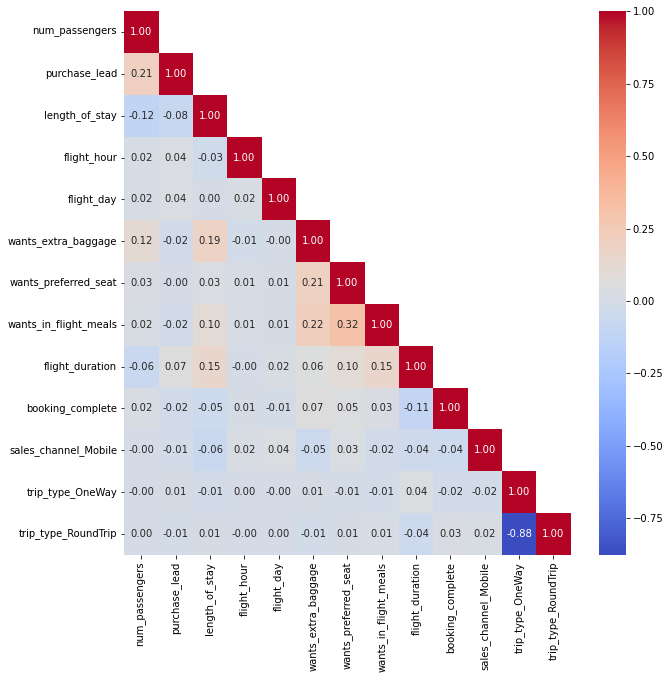

In [24]:
# visualize a correlation matrix with half of the heatmap cut off
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f', mask=np.triu(df.corr(), k=1))
plt.show()

### Prepare the data for modelling

In [28]:
# Split the data into features and target
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Print shape of scaled features and target
X_scaled.shape, y.shape

((49959, 12), (49959,))

In [30]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Print shape of training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39967, 12), (9992, 12), (39967,), (9992,))

In [64]:
# Instantiate a random forest classifier
rf = RandomForestClassifier(random_state=42, max_depth=100, n_estimators=10, class_weight={0:85, 1:15})

# Fit the classifier to the training data
rf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = rf.predict(X_test)

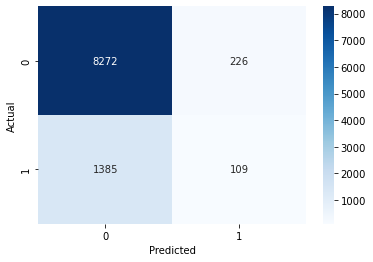

In [65]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [66]:
# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('F1 score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))

Accuracy: 0.84
F1 score: 0.12
Precision: 0.33
Recall: 0.07


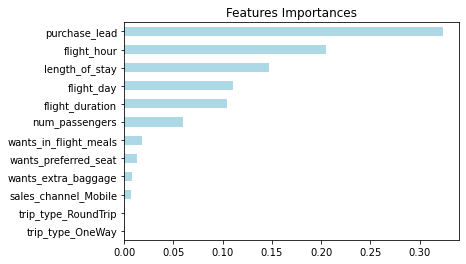

In [67]:
# Plot the feature importances
importances = pd.Series(data=rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importances')
plt.show()

In [68]:
# Use SMOTE to oversample the minority class
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Print shape of resampled training data
X_train_res.shape, y_train_res.shape

((67982, 12), (67982,))

In [72]:
y_train_res.value_counts()

0    33991
1    33991
Name: booking_complete, dtype: int64

In [76]:
# Instantiate a random forest classifier
rf = RandomForestClassifier(random_state=42, max_depth=50, n_estimators=50)

# Fit the classifier to the training data
rf.fit(X_train_res, y_train_res)

# Predict the labels of the test set
y_pred = rf.predict(X_test)

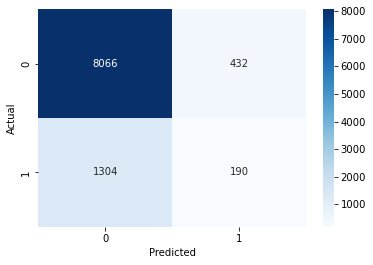

In [77]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [78]:
# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('F1 score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))

Accuracy: 0.83
F1 score: 0.18
Precision: 0.31
Recall: 0.13


### Use a XGBoost classifier

In [96]:
# Train a XGBoost classifier
xgb = XGBClassifier(random_state=42, max_depth=10, n_estimators=100, learning_rate=0.1,
                    scale_pos_weight=10)

# Fit the classifier to the training data
xgb.fit(X_train_res, y_train_res)

# Predict the labels of the test set
y_pred = xgb.predict(X_test)

# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('F1 score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))

Accuracy: 0.55
F1 score: 0.32
Precision: 0.21
Recall: 0.70


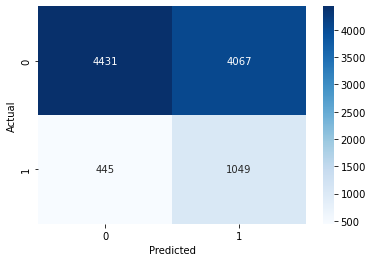

In [97]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

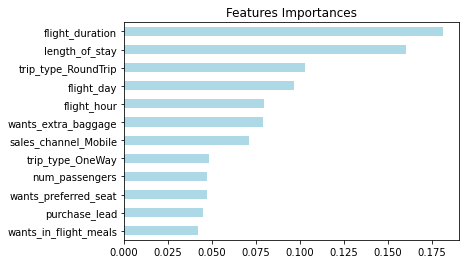

In [98]:
# Plot the feature importances
importances = pd.Series(data=xgb.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importances')
plt.show()